# Train on notebook

In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [5]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [6]:
torch.randint(0, len(tree_src.antibodies), (1,)).item()


53

In [7]:
idx_src = torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  216
idx_dst:  193


In [8]:
pipeline = OSGenPipeline()


/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
trainable_params = sum(p.numel() for p in pipeline.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 88957769


In [10]:
count = 0
count_float32 = 0
for name, module in pipeline.named_modules():
    for param_name, param in module.named_parameters(recurse=False):
        # print(f"{name}.{param_name}: dtype={param.dtype}")
        if param.dtype == torch.float32:
            count_float32 += 1
        count += 1

print(f"float32 percentage: {count_float32 / count * 100}%")


float32 percentage: 100.0%


In [ ]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = cfg.num_epochs
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_losses = []
    avg_loss = []
    
    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()


    current_loss = np.mean(avg_loss)
    losses.append(current_loss)
    content_losses.append(content_l.item())
    style_losses.append(style_l.item())

    # Early stopping
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        if num_epochs > 100: 
            print(f"Early stopping at epoch {epoch+1}")
            break 

    # if verbose: 
    #     if epoch % 10 == 0:
    #         print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
    #             f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
    #             f"Total Loss: {total_loss.item():.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# After your training loop
# Save model components
torch.save(pipeline.state_dict(), '/root/BiOSGen/checkpoints/pipeline.pth')

# Save the entire model state including optimizer
checkpoint = {
    'epoch': epoch,
    'model_state_dict': pipeline.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
    'losses': losses,
    'content_losses': content_losses,
    'style_losses': style_losses
}

torch.save(checkpoint, '/root/BiOSGen/checkpoints/pipeline_full.pth')

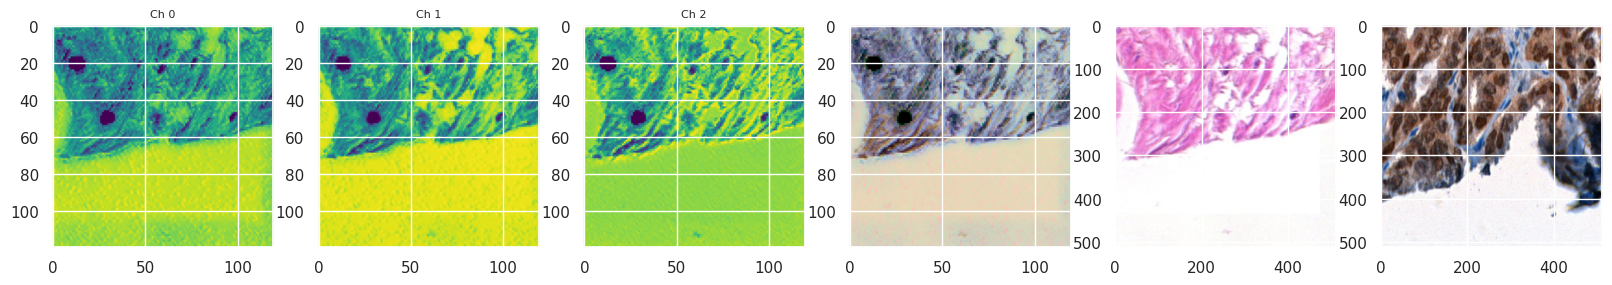

In [ ]:
decoded = decoded.to(torch.uint8)
fig, axes = plt.subplots(1, 6, figsize=(20, 15))  # 1x5 grid
for i in range(3):
    ax = axes[i]
    ax.imshow(decoded[0, i].detach().cpu().numpy(), cmap='viridis')
    ax.set_title(f'Ch {i}', fontsize=8)
    # ax.axis('off')

axes[3].imshow(decoded[0].permute(1,2,0).detach().cpu().numpy(), cmap='viridis')
axes[4].imshow(src, cmap='viridis')
axes[5].imshow(dst, cmap='viridis')

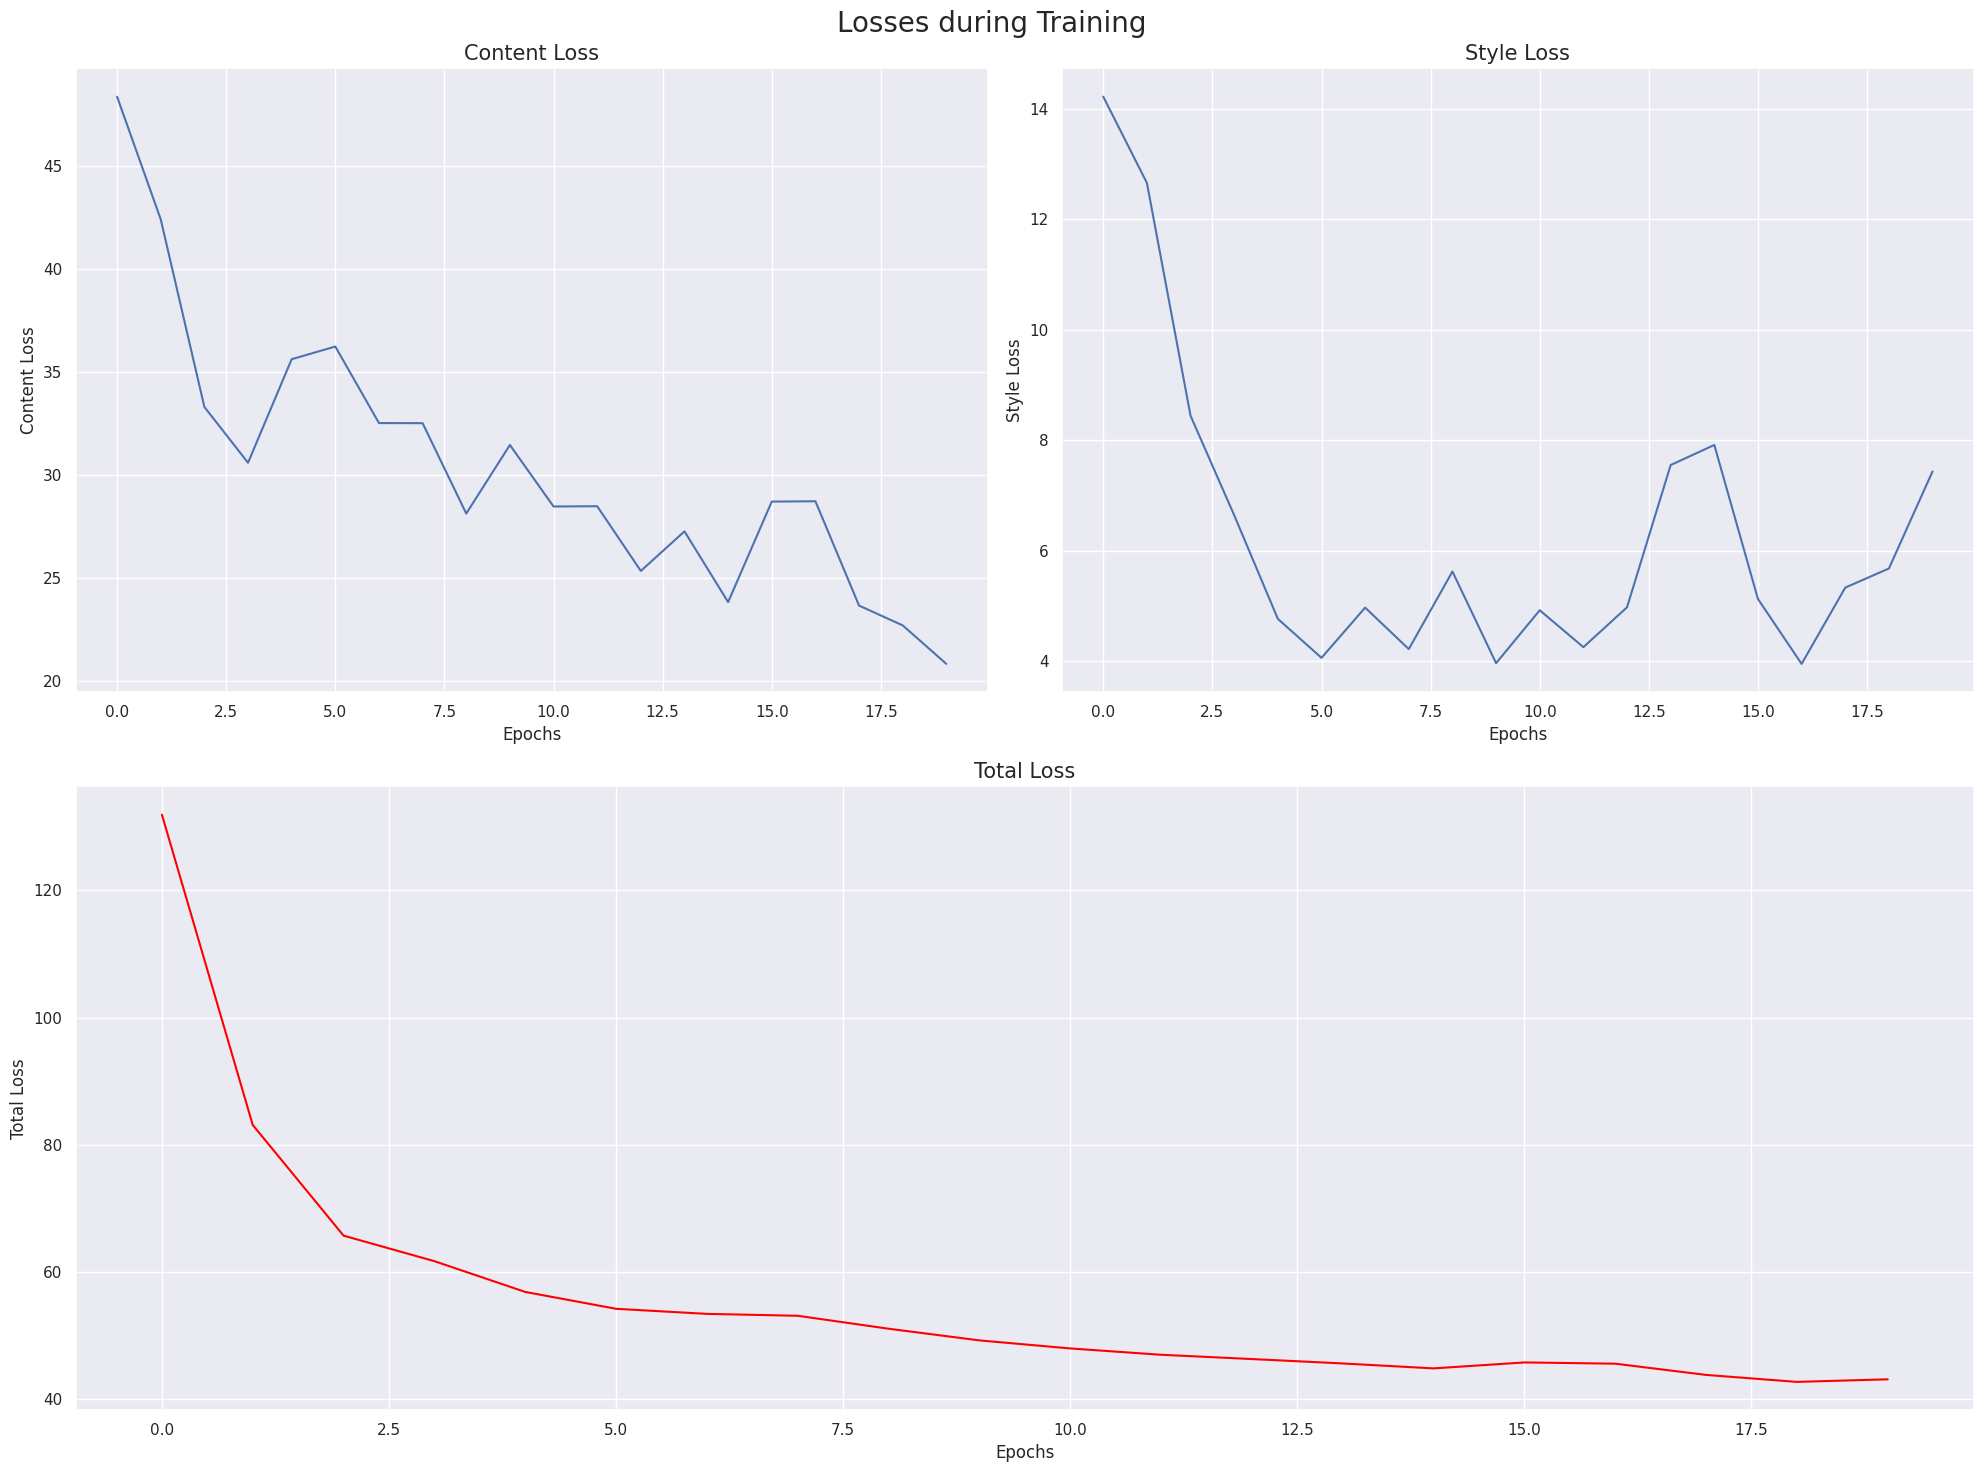

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Upper left: Content Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(content_losses, label='Content Loss')
ax1.set_title('Content Loss', fontsize=15)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Content Loss')

# Upper right: Style Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(style_losses, label='Style Loss')
ax2.set_title('Style Loss', fontsize=15)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Style Loss')

# Bottom (spans both columns): Total Loss
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(losses, label='Total Loss', color='red')
ax3.set_title('Total Loss', fontsize=15)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Total Loss')

# Add title to fig
fig.suptitle('Losses during Training', fontsize=20)
plt.tight_layout()
plt.show()
